## Dataset

In [1]:
# download dữ liệu về
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=c8d14e64-b484-46e2-93d0-bec62074166e
To: /content/celeba_hq_256.zip
100% 297M/297M [00:07<00:00, 39.4MB/s]


In [2]:
# unzip dữ liệu
!unzip celeba_hq_256.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: celeba_hq_256/25000.jpg  
  inflating: celeba_hq_256/25001.jpg  
  inflating: celeba_hq_256/25002.jpg  
  inflating: celeba_hq_256/25003.jpg  
  inflating: celeba_hq_256/25004.jpg  
  inflating: celeba_hq_256/25005.jpg  
  inflating: celeba_hq_256/25006.jpg  
  inflating: celeba_hq_256/25007.jpg  
  inflating: celeba_hq_256/25008.jpg  
  inflating: celeba_hq_256/25009.jpg  
  inflating: celeba_hq_256/25010.jpg  
  inflating: celeba_hq_256/25011.jpg  
  inflating: celeba_hq_256/25012.jpg  
  inflating: celeba_hq_256/25013.jpg  
  inflating: celeba_hq_256/25014.jpg  
  inflating: celeba_hq_256/25015.jpg  
  inflating: celeba_hq_256/25016.jpg  
  inflating: celeba_hq_256/25017.jpg  
  inflating: celeba_hq_256/25018.jpg  
  inflating: celeba_hq_256/25019.jpg  
  inflating: celeba_hq_256/25020.jpg  
  inflating: celeba_hq_256/25021.jpg  
  inflating: celeba_hq_256/25022.jpg  
  inflating: celeba_hq_256/25023.jpg  
  infla

In [4]:
import os

# lấy từng path của dữ liệu đang có
file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [5]:
# chia tập dữ liệu thành train, và test
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size) # lấy randomm 90% dữ liệu bên trong
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [6]:
# xây dựng một hàm làm mask
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]
    mask = np.zeros((height, width, 1), dtype=dtype) # tạo một loạt các cell = 0
    # tất cả các dũ liệu bên trong box đề là 1
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask


In [7]:
# xây dựng lại hàm inpainting dataset
from torch.utils.data import Dataset # import Dataset from torch.utils.data
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
      self.img_paths = img_paths
      self.image_size = image_size
      self.transform = transforms.Compose([
          transforms.Resize(image_size),
          transforms.ToTensor(),
          #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
      ])

    def __len__(self):
      return len(self.img_paths)

    def __getitem__(self, index):
      img_path = self.img_paths[index]
      img = Image.open(img_path).convert('RGB')
      img = self.transform(img)
      mask = self.get_mask()
      # mục đích là để cho tất cả các cell trong mask đều bằng 1
      # các cell ngoài mask thì sẽ được giữ nguyên
      cond_image = img * (1. - mask) + mask*torch.randn_like(img)
      mask_image = img * (1. - mask) + mask
      return {
        'gt_image': img,
        'cond_image': cond_image,
        'mask_image': mask_image,
        'mask': mask,
        "path": img_path
     }

    def get_mask(self):
      #if self.mask_mode == 'center':
      h, w =  self.image_size
      mask = bbox2mask(self.image_size, [h//4, w//4, h//2, w//2])
      #else:
        #raise NotImplementedError(
           # f'Mask mode {self.mask_mode} is not implemented'
        #)
      return torch.from_numpy(mask).permute(2, 0, 1)

In [8]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)


In [10]:
sample = next(iter(train_dataset)) # lấy một patch ra để kiểm tra

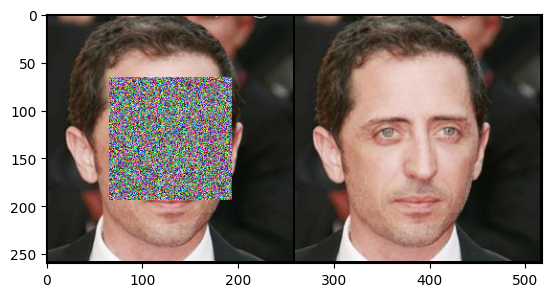

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [12]:
! pip install -q torchcfm

In [13]:
from torchcfm.models.unet import UNetModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [14]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data['gt_image'].to(device) # gt
        x0 = torch.randn_like(x1).to(device) # nhiễu được tạo ra
        mask = data['mask'].to(device) # condition image

        x_noise = x1 * (1. - mask) + x0 * mask
        t = torch.rand(1).to(device)  # Random time step t
        xt = t * x1 + (1 - t) * x0  # Interpolated data point
        ut = x1 - x0  # True difference (velocity)

        # Model prediction
        t = t.squeeze()
        x_cond = xt*mask + x1*(1-mask)
        vt = model(t, x_cond)


        loss = torch.mean(((vt - ut) ** 2)*mask)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

6it [00:04,  1.41it/s]


epoch: 0, loss: 0.289


6it [00:03,  1.79it/s]


epoch: 1, loss: 0.2164


6it [00:03,  1.75it/s]


epoch: 2, loss: 0.1268


6it [00:03,  1.81it/s]


epoch: 3, loss: 0.08464


6it [00:03,  1.81it/s]


epoch: 4, loss: 0.1008


6it [00:03,  1.81it/s]


epoch: 5, loss: 0.03999


6it [00:03,  1.75it/s]


epoch: 6, loss: 0.03378


6it [00:03,  1.81it/s]


epoch: 7, loss: 0.04643


6it [00:03,  1.82it/s]


epoch: 8, loss: 0.02687


6it [00:03,  1.82it/s]


epoch: 9, loss: 0.06388


6it [00:03,  1.51it/s]


epoch: 10, loss: 0.05432


6it [00:03,  1.77it/s]


epoch: 11, loss: 0.02939


6it [00:03,  1.79it/s]


epoch: 12, loss: 0.0308


6it [00:03,  1.75it/s]


epoch: 13, loss: 0.02284


6it [00:03,  1.75it/s]


epoch: 14, loss: 0.02779


6it [00:03,  1.78it/s]


epoch: 15, loss: 0.01869


6it [00:03,  1.69it/s]


epoch: 16, loss: 0.01975


6it [00:03,  1.73it/s]


epoch: 17, loss: 0.01764


6it [00:03,  1.79it/s]


epoch: 18, loss: 0.02194


6it [00:03,  1.78it/s]


epoch: 19, loss: 0.03138


6it [00:03,  1.77it/s]


epoch: 20, loss: 0.01942


6it [00:03,  1.71it/s]


epoch: 21, loss: 0.03427


6it [00:03,  1.76it/s]


epoch: 22, loss: 0.02507


6it [00:03,  1.76it/s]


epoch: 23, loss: 0.06576


6it [00:03,  1.73it/s]


epoch: 24, loss: 0.04723


6it [00:03,  1.73it/s]


epoch: 25, loss: 0.02368


6it [00:03,  1.76it/s]


epoch: 26, loss: 0.0226


6it [00:03,  1.75it/s]


epoch: 27, loss: 0.01812


6it [00:03,  1.69it/s]


epoch: 28, loss: 0.01513


6it [00:03,  1.75it/s]


epoch: 29, loss: 0.02731


6it [00:03,  1.73it/s]


epoch: 30, loss: 0.03982


6it [00:03,  1.72it/s]


epoch: 31, loss: 0.01782


6it [00:03,  1.67it/s]


epoch: 32, loss: 0.01648


6it [00:03,  1.73it/s]


epoch: 33, loss: 0.01567


6it [00:03,  1.73it/s]


epoch: 34, loss: 0.02768


6it [00:03,  1.69it/s]


epoch: 35, loss: 0.02863


6it [00:03,  1.73it/s]


epoch: 36, loss: 0.02909


6it [00:03,  1.74it/s]


epoch: 37, loss: 0.02193


6it [00:03,  1.75it/s]


epoch: 38, loss: 0.02871


6it [00:03,  1.68it/s]


epoch: 39, loss: 0.0389


6it [00:03,  1.75it/s]


epoch: 40, loss: 0.06436


6it [00:03,  1.74it/s]


epoch: 41, loss: 0.02583


6it [00:03,  1.72it/s]


epoch: 42, loss: 0.03173


6it [00:03,  1.73it/s]


epoch: 43, loss: 0.01916


6it [00:03,  1.75it/s]


epoch: 44, loss: 0.01862


6it [00:03,  1.76it/s]


epoch: 45, loss: 0.05976


6it [00:03,  1.69it/s]


epoch: 46, loss: 0.03099


6it [00:03,  1.75it/s]


epoch: 47, loss: 0.03848


6it [00:03,  1.74it/s]


epoch: 48, loss: 0.02425


6it [00:03,  1.73it/s]


epoch: 49, loss: 0.01737


6it [00:03,  1.70it/s]


epoch: 50, loss: 0.03731


6it [00:03,  1.75it/s]


epoch: 51, loss: 0.02212


6it [00:03,  1.74it/s]


epoch: 52, loss: 0.01659


6it [00:03,  1.70it/s]


epoch: 53, loss: 0.02045


6it [00:03,  1.73it/s]


epoch: 54, loss: 0.01805


6it [00:03,  1.74it/s]


epoch: 55, loss: 0.01736


6it [00:03,  1.74it/s]


epoch: 56, loss: 0.019


6it [00:03,  1.68it/s]


epoch: 57, loss: 0.01461


6it [00:03,  1.74it/s]


epoch: 58, loss: 0.01629


6it [00:03,  1.73it/s]


epoch: 59, loss: 0.0146


6it [00:03,  1.71it/s]


epoch: 60, loss: 0.05857


6it [00:03,  1.71it/s]


epoch: 61, loss: 0.01488


6it [00:03,  1.74it/s]


epoch: 62, loss: 0.02042


6it [00:03,  1.74it/s]


epoch: 63, loss: 0.01613


6it [00:03,  1.69it/s]


epoch: 64, loss: 0.01556


6it [00:03,  1.74it/s]


epoch: 65, loss: 0.01352


6it [00:03,  1.69it/s]


epoch: 66, loss: 0.01575


6it [00:03,  1.73it/s]


epoch: 67, loss: 0.0148


6it [00:03,  1.71it/s]


epoch: 68, loss: 0.01498


6it [00:03,  1.74it/s]


epoch: 69, loss: 0.02748


6it [00:03,  1.75it/s]


epoch: 70, loss: 0.0143


6it [00:03,  1.69it/s]


epoch: 71, loss: 0.02132


6it [00:03,  1.75it/s]


epoch: 72, loss: 0.05593


6it [00:03,  1.74it/s]


epoch: 73, loss: 0.03375


6it [00:03,  1.75it/s]


epoch: 74, loss: 0.01485


6it [00:03,  1.69it/s]


epoch: 75, loss: 0.01448


6it [00:03,  1.74it/s]


epoch: 76, loss: 0.01143


6it [00:03,  1.74it/s]


epoch: 77, loss: 0.01642


6it [00:03,  1.71it/s]


epoch: 78, loss: 0.01514


6it [00:03,  1.73it/s]


epoch: 79, loss: 0.05257


6it [00:03,  1.75it/s]


epoch: 80, loss: 0.01798


6it [00:03,  1.74it/s]


epoch: 81, loss: 0.01796


6it [00:03,  1.68it/s]


epoch: 82, loss: 0.01731


6it [00:03,  1.74it/s]


epoch: 83, loss: 0.05826


6it [00:03,  1.75it/s]


epoch: 84, loss: 0.01494


6it [00:03,  1.72it/s]


epoch: 85, loss: 0.01804


6it [00:03,  1.70it/s]


epoch: 86, loss: 0.01545


6it [00:03,  1.73it/s]


epoch: 87, loss: 0.01413


6it [00:03,  1.74it/s]


epoch: 88, loss: 0.01274


6it [00:03,  1.70it/s]


epoch: 89, loss: 0.0314


6it [00:03,  1.74it/s]


epoch: 90, loss: 0.01095


6it [00:03,  1.73it/s]


epoch: 91, loss: 0.03498


6it [00:03,  1.72it/s]


epoch: 92, loss: 0.02089


6it [00:03,  1.68it/s]


epoch: 93, loss: 0.02348


6it [00:03,  1.74it/s]


epoch: 94, loss: 0.02314


6it [00:03,  1.74it/s]


epoch: 95, loss: 0.0187


6it [00:03,  1.69it/s]


epoch: 96, loss: 0.01636


6it [00:03,  1.73it/s]


epoch: 97, loss: 0.02036


6it [00:03,  1.74it/s]


epoch: 98, loss: 0.01304


6it [00:03,  1.74it/s]


epoch: 99, loss: 0.01401


6it [00:03,  1.67it/s]


epoch: 100, loss: 0.04035


6it [00:03,  1.74it/s]


epoch: 101, loss: 0.02954


6it [00:03,  1.72it/s]


epoch: 102, loss: 0.01613


6it [00:03,  1.72it/s]


epoch: 103, loss: 0.01215


6it [00:03,  1.70it/s]


epoch: 104, loss: 0.02041


6it [00:03,  1.74it/s]


epoch: 105, loss: 0.04539


6it [00:03,  1.74it/s]


epoch: 106, loss: 0.016


6it [00:03,  1.68it/s]


epoch: 107, loss: 0.01676


6it [00:03,  1.74it/s]


epoch: 108, loss: 0.02658


6it [00:03,  1.75it/s]


epoch: 109, loss: 0.01581


6it [00:03,  1.72it/s]


epoch: 110, loss: 0.02045


6it [00:03,  1.70it/s]


epoch: 111, loss: 0.01194


6it [00:03,  1.75it/s]


epoch: 112, loss: 0.02286


6it [00:03,  1.74it/s]


epoch: 113, loss: 0.07228


6it [00:03,  1.71it/s]


epoch: 114, loss: 0.01098


6it [00:03,  1.72it/s]


epoch: 115, loss: 0.01308


6it [00:03,  1.75it/s]


epoch: 116, loss: 0.01447


6it [00:03,  1.74it/s]


epoch: 117, loss: 0.01285


6it [00:03,  1.69it/s]


epoch: 118, loss: 0.01359


6it [00:03,  1.74it/s]


epoch: 119, loss: 0.01466


6it [00:03,  1.75it/s]


epoch: 120, loss: 0.01618


6it [00:03,  1.72it/s]


epoch: 121, loss: 0.01898


6it [00:03,  1.71it/s]


epoch: 122, loss: 0.05573


6it [00:03,  1.73it/s]


epoch: 123, loss: 0.01952


6it [00:03,  1.75it/s]


epoch: 124, loss: 0.04398


6it [00:03,  1.67it/s]


epoch: 125, loss: 0.01795


6it [00:03,  1.74it/s]


epoch: 126, loss: 0.0499


6it [00:03,  1.73it/s]


epoch: 127, loss: 0.01417


6it [00:03,  1.72it/s]


epoch: 128, loss: 0.0193


6it [00:03,  1.50it/s]


epoch: 129, loss: 0.01546


6it [00:03,  1.73it/s]


epoch: 130, loss: 0.01882


6it [00:03,  1.72it/s]


epoch: 131, loss: 0.01432


6it [00:03,  1.71it/s]


epoch: 132, loss: 0.0114


6it [00:03,  1.73it/s]


epoch: 133, loss: 0.0119


6it [00:03,  1.73it/s]


epoch: 134, loss: 0.01108


6it [00:03,  1.73it/s]


epoch: 135, loss: 0.01434


6it [00:03,  1.68it/s]


epoch: 136, loss: 0.01612


6it [00:03,  1.74it/s]


epoch: 137, loss: 0.03089


6it [00:03,  1.73it/s]


epoch: 138, loss: 0.01281


6it [00:03,  1.72it/s]


epoch: 139, loss: 0.01815


6it [00:03,  1.70it/s]


epoch: 140, loss: 0.01495


6it [00:03,  1.74it/s]


epoch: 141, loss: 0.01021


6it [00:03,  1.74it/s]


epoch: 142, loss: 0.01565


6it [00:03,  1.68it/s]


epoch: 143, loss: 0.02556


6it [00:03,  1.73it/s]


epoch: 144, loss: 0.0114


6it [00:03,  1.75it/s]


epoch: 145, loss: 0.01688


6it [00:03,  1.73it/s]


epoch: 146, loss: 0.03823


6it [00:03,  1.70it/s]


epoch: 147, loss: 0.0135


6it [00:03,  1.66it/s]


epoch: 148, loss: 0.01315


6it [00:03,  1.74it/s]


epoch: 149, loss: 0.01679


6it [00:03,  1.68it/s]


epoch: 150, loss: 0.01306


6it [00:03,  1.74it/s]


epoch: 151, loss: 0.0112


6it [00:03,  1.73it/s]


epoch: 152, loss: 0.01579


6it [00:03,  1.73it/s]


epoch: 153, loss: 0.01069


6it [00:03,  1.70it/s]


epoch: 154, loss: 0.009909


6it [00:03,  1.75it/s]


epoch: 155, loss: 0.01889


6it [00:03,  1.75it/s]


epoch: 156, loss: 0.01265


6it [00:03,  1.69it/s]


epoch: 157, loss: 0.01561


6it [00:03,  1.72it/s]


epoch: 158, loss: 0.01172


6it [00:03,  1.74it/s]


epoch: 159, loss: 0.01152


6it [00:03,  1.73it/s]


epoch: 160, loss: 0.01842


6it [00:03,  1.69it/s]


epoch: 161, loss: 0.01119


6it [00:03,  1.73it/s]


epoch: 162, loss: 0.009523


6it [00:03,  1.74it/s]


epoch: 163, loss: 0.02568


6it [00:03,  1.71it/s]


epoch: 164, loss: 0.02323


6it [00:03,  1.71it/s]


epoch: 165, loss: 0.01338


6it [00:03,  1.76it/s]


epoch: 166, loss: 0.03315


6it [00:03,  1.72it/s]


epoch: 167, loss: 0.02931


6it [00:03,  1.68it/s]


epoch: 168, loss: 0.01378


6it [00:03,  1.75it/s]


epoch: 169, loss: 0.01381


6it [00:03,  1.74it/s]


epoch: 170, loss: 0.01142


6it [00:03,  1.72it/s]


epoch: 171, loss: 0.04322


6it [00:03,  1.69it/s]


epoch: 172, loss: 0.01215


6it [00:03,  1.75it/s]


epoch: 173, loss: 0.01689


6it [00:03,  1.74it/s]


epoch: 174, loss: 0.01177


6it [00:03,  1.68it/s]


epoch: 175, loss: 0.01223


6it [00:03,  1.73it/s]


epoch: 176, loss: 0.01167


6it [00:03,  1.74it/s]


epoch: 177, loss: 0.01592


6it [00:03,  1.75it/s]


epoch: 178, loss: 0.01048


6it [00:03,  1.68it/s]


epoch: 179, loss: 0.0459


6it [00:03,  1.73it/s]


epoch: 180, loss: 0.01052


6it [00:03,  1.75it/s]


epoch: 181, loss: 0.009115


6it [00:03,  1.70it/s]


epoch: 182, loss: 0.01789


6it [00:03,  1.73it/s]


epoch: 183, loss: 0.03996


6it [00:03,  1.74it/s]


epoch: 184, loss: 0.01623


6it [00:03,  1.72it/s]


epoch: 185, loss: 0.01254


6it [00:03,  1.68it/s]


epoch: 186, loss: 0.01205


6it [00:03,  1.74it/s]


epoch: 187, loss: 0.02289


6it [00:03,  1.73it/s]


epoch: 188, loss: 0.01263


6it [00:03,  1.70it/s]


epoch: 189, loss: 0.01815


6it [00:03,  1.71it/s]


epoch: 190, loss: 0.01261


6it [00:03,  1.73it/s]


epoch: 191, loss: 0.01415


6it [00:03,  1.74it/s]


epoch: 192, loss: 0.01144


6it [00:03,  1.68it/s]


epoch: 193, loss: 0.01592


6it [00:03,  1.75it/s]


epoch: 194, loss: 0.01073


6it [00:03,  1.68it/s]


epoch: 195, loss: 0.01238


6it [00:03,  1.71it/s]


epoch: 196, loss: 0.01133


6it [00:03,  1.69it/s]


epoch: 197, loss: 0.01429


6it [00:03,  1.74it/s]


epoch: 198, loss: 0.01162


6it [00:03,  1.74it/s]


epoch: 199, loss: 0.00968


6it [00:03,  1.68it/s]


epoch: 200, loss: 0.01102


6it [00:03,  1.73it/s]


epoch: 201, loss: 0.01089


6it [00:03,  1.74it/s]


epoch: 202, loss: 0.01225


6it [00:03,  1.74it/s]


epoch: 203, loss: 0.0151


6it [00:03,  1.69it/s]


epoch: 204, loss: 0.02719


6it [00:03,  1.74it/s]


epoch: 205, loss: 0.01679


6it [00:03,  1.74it/s]


epoch: 206, loss: 0.01302


6it [00:03,  1.70it/s]


epoch: 207, loss: 0.008831


6it [00:03,  1.73it/s]


epoch: 208, loss: 0.0237


6it [00:03,  1.73it/s]


epoch: 209, loss: 0.01206


6it [00:03,  1.74it/s]


epoch: 210, loss: 0.01781


6it [00:03,  1.67it/s]


epoch: 211, loss: 0.01062


6it [00:03,  1.73it/s]


epoch: 212, loss: 0.01286


6it [00:03,  1.74it/s]


epoch: 213, loss: 0.01047


6it [00:03,  1.71it/s]


epoch: 214, loss: 0.009229


6it [00:03,  1.69it/s]


epoch: 215, loss: 0.0116


6it [00:03,  1.74it/s]


epoch: 216, loss: 0.01419


6it [00:03,  1.75it/s]


epoch: 217, loss: 0.009656


6it [00:03,  1.68it/s]


epoch: 218, loss: 0.008002


6it [00:03,  1.74it/s]


epoch: 219, loss: 0.01123


6it [00:03,  1.74it/s]


epoch: 220, loss: 0.009269


6it [00:03,  1.73it/s]


epoch: 221, loss: 0.008525


6it [00:03,  1.70it/s]


epoch: 222, loss: 0.01257


6it [00:03,  1.74it/s]


epoch: 223, loss: 0.04176


6it [00:03,  1.74it/s]


epoch: 224, loss: 0.01002


6it [00:03,  1.69it/s]


epoch: 225, loss: 0.0172


6it [00:03,  1.73it/s]


epoch: 226, loss: 0.009017


6it [00:03,  1.74it/s]


epoch: 227, loss: 0.01491


6it [00:03,  1.73it/s]


epoch: 228, loss: 0.01368


6it [00:03,  1.69it/s]


epoch: 229, loss: 0.009245


6it [00:03,  1.74it/s]


epoch: 230, loss: 0.009537


6it [00:03,  1.74it/s]


epoch: 231, loss: 0.009498


6it [00:03,  1.71it/s]


epoch: 232, loss: 0.02309


6it [00:03,  1.69it/s]


epoch: 233, loss: 0.01128


6it [00:03,  1.75it/s]


epoch: 234, loss: 0.01249


6it [00:03,  1.75it/s]


epoch: 235, loss: 0.009992


6it [00:03,  1.69it/s]


epoch: 236, loss: 0.01131


6it [00:03,  1.75it/s]


epoch: 237, loss: 0.01622


6it [00:03,  1.74it/s]


epoch: 238, loss: 0.008876


6it [00:03,  1.73it/s]


epoch: 239, loss: 0.01022


6it [00:03,  1.69it/s]


epoch: 240, loss: 0.009029


6it [00:03,  1.73it/s]


epoch: 241, loss: 0.01215


6it [00:03,  1.74it/s]


epoch: 242, loss: 0.01124


6it [00:03,  1.67it/s]


epoch: 243, loss: 0.01762


6it [00:03,  1.74it/s]


epoch: 244, loss: 0.06556


6it [00:03,  1.74it/s]


epoch: 245, loss: 0.01572


6it [00:03,  1.74it/s]


epoch: 246, loss: 0.01412


6it [00:03,  1.69it/s]


epoch: 247, loss: 0.01318


6it [00:03,  1.74it/s]


epoch: 248, loss: 0.01653


6it [00:03,  1.74it/s]


epoch: 249, loss: 0.01131


6it [00:03,  1.71it/s]


epoch: 250, loss: 0.009712


6it [00:03,  1.73it/s]


epoch: 251, loss: 0.01033


6it [00:03,  1.74it/s]


epoch: 252, loss: 0.01601


6it [00:03,  1.74it/s]


epoch: 253, loss: 0.008244


6it [00:03,  1.69it/s]


epoch: 254, loss: 0.03556


6it [00:03,  1.74it/s]


epoch: 255, loss: 0.01056


6it [00:03,  1.75it/s]


epoch: 256, loss: 0.009258


6it [00:03,  1.71it/s]


epoch: 257, loss: 0.01349


6it [00:03,  1.71it/s]


epoch: 258, loss: 0.02074


6it [00:03,  1.74it/s]


epoch: 259, loss: 0.02048


6it [00:03,  1.68it/s]


epoch: 260, loss: 0.01054


6it [00:03,  1.69it/s]


epoch: 261, loss: 0.01175


6it [00:03,  1.74it/s]


epoch: 262, loss: 0.01074


6it [00:03,  1.74it/s]


epoch: 263, loss: 0.01084


6it [00:03,  1.71it/s]


epoch: 264, loss: 0.009387


6it [00:03,  1.69it/s]


epoch: 265, loss: 0.00906


6it [00:03,  1.74it/s]


epoch: 266, loss: 0.008877


6it [00:03,  1.75it/s]


epoch: 267, loss: 0.02169


6it [00:03,  1.69it/s]


epoch: 268, loss: 0.01107


6it [00:03,  1.74it/s]


epoch: 269, loss: 0.01265


6it [00:03,  1.73it/s]


epoch: 270, loss: 0.01228


6it [00:03,  1.73it/s]


epoch: 271, loss: 0.009551


6it [00:03,  1.70it/s]


epoch: 272, loss: 0.009975


6it [00:03,  1.74it/s]


epoch: 273, loss: 0.01308


6it [00:03,  1.74it/s]


epoch: 274, loss: 0.01015


6it [00:03,  1.69it/s]


epoch: 275, loss: 0.0116


6it [00:03,  1.72it/s]


epoch: 276, loss: 0.009224


6it [00:03,  1.73it/s]


epoch: 277, loss: 0.03819


6it [00:03,  1.74it/s]


epoch: 278, loss: 0.01135


6it [00:03,  1.69it/s]


epoch: 279, loss: 0.01803


6it [00:03,  1.74it/s]


epoch: 280, loss: 0.01808


6it [00:03,  1.74it/s]


epoch: 281, loss: 0.007931


6it [00:03,  1.71it/s]


epoch: 282, loss: 0.01166


6it [00:03,  1.72it/s]


epoch: 283, loss: 0.009608


6it [00:03,  1.74it/s]


epoch: 284, loss: 0.01038


6it [00:03,  1.75it/s]


epoch: 285, loss: 0.01135


6it [00:03,  1.68it/s]


epoch: 286, loss: 0.008863


6it [00:03,  1.74it/s]


epoch: 287, loss: 0.01122


6it [00:03,  1.74it/s]


epoch: 288, loss: 0.007232


6it [00:03,  1.72it/s]


epoch: 289, loss: 0.00804


6it [00:03,  1.70it/s]


epoch: 290, loss: 0.008488


6it [00:03,  1.74it/s]


epoch: 291, loss: 0.01952


6it [00:03,  1.75it/s]


epoch: 292, loss: 0.01233


6it [00:03,  1.69it/s]


epoch: 293, loss: 0.007076


6it [00:03,  1.72it/s]


epoch: 294, loss: 0.01883


6it [00:03,  1.74it/s]


epoch: 295, loss: 0.01037


6it [00:03,  1.74it/s]


epoch: 296, loss: 0.007897


6it [00:03,  1.68it/s]


epoch: 297, loss: 0.0115


6it [00:03,  1.73it/s]


epoch: 298, loss: 0.007987


6it [00:03,  1.75it/s]


epoch: 299, loss: 0.007561


6it [00:03,  1.71it/s]


epoch: 300, loss: 0.01579


6it [00:03,  1.70it/s]


epoch: 301, loss: 0.01305


6it [00:03,  1.73it/s]


epoch: 302, loss: 0.01234


6it [00:03,  1.74it/s]


epoch: 303, loss: 0.01439


6it [00:03,  1.68it/s]


epoch: 304, loss: 0.02196


6it [00:03,  1.75it/s]


epoch: 305, loss: 0.008811


6it [00:03,  1.74it/s]


epoch: 306, loss: 0.01079


6it [00:03,  1.73it/s]


epoch: 307, loss: 0.01207


6it [00:03,  1.68it/s]


epoch: 308, loss: 0.007961


6it [00:03,  1.74it/s]


epoch: 309, loss: 0.01453


6it [00:03,  1.73it/s]


epoch: 310, loss: 0.009795


6it [00:03,  1.69it/s]


epoch: 311, loss: 0.007383


6it [00:03,  1.75it/s]


epoch: 312, loss: 0.01964


6it [00:03,  1.74it/s]


epoch: 313, loss: 0.00941


6it [00:03,  1.73it/s]


epoch: 314, loss: 0.008368


6it [00:03,  1.67it/s]


epoch: 315, loss: 0.01012


6it [00:03,  1.73it/s]


epoch: 316, loss: 0.007591


6it [00:03,  1.75it/s]


epoch: 317, loss: 0.007065


6it [00:03,  1.71it/s]


epoch: 318, loss: 0.007799


6it [00:03,  1.70it/s]


epoch: 319, loss: 0.01072


6it [00:03,  1.73it/s]


epoch: 320, loss: 0.01413


6it [00:03,  1.74it/s]


epoch: 321, loss: 0.008965


6it [00:03,  1.67it/s]


epoch: 322, loss: 0.006638


6it [00:03,  1.74it/s]


epoch: 323, loss: 0.007384


6it [00:03,  1.72it/s]


epoch: 324, loss: 0.02365


6it [00:03,  1.66it/s]


epoch: 325, loss: 0.01599


6it [00:03,  1.71it/s]


epoch: 326, loss: 0.007423


6it [00:03,  1.73it/s]


epoch: 327, loss: 0.008214


6it [00:03,  1.73it/s]


epoch: 328, loss: 0.0114


6it [00:03,  1.68it/s]


epoch: 329, loss: 0.00915


6it [00:03,  1.74it/s]


epoch: 330, loss: 0.01079


6it [00:03,  1.75it/s]


epoch: 331, loss: 0.006713


6it [00:03,  1.71it/s]


epoch: 332, loss: 0.01127


6it [00:03,  1.67it/s]


epoch: 333, loss: 0.007216


6it [00:03,  1.74it/s]


epoch: 334, loss: 0.008704


6it [00:03,  1.72it/s]


epoch: 335, loss: 0.02487


6it [00:03,  1.68it/s]


epoch: 336, loss: 0.009763


6it [00:03,  1.73it/s]


epoch: 337, loss: 0.01783


6it [00:03,  1.74it/s]


epoch: 338, loss: 0.00725


6it [00:03,  1.72it/s]


epoch: 339, loss: 0.02761


6it [00:03,  1.68it/s]


epoch: 340, loss: 0.01484


6it [00:03,  1.74it/s]


epoch: 341, loss: 0.01247


6it [00:03,  1.73it/s]


epoch: 342, loss: 0.02162


6it [00:03,  1.70it/s]


epoch: 343, loss: 0.009478


6it [00:03,  1.71it/s]


epoch: 344, loss: 0.01613


6it [00:03,  1.74it/s]


epoch: 345, loss: 0.01117


6it [00:03,  1.74it/s]


epoch: 346, loss: 0.01507


6it [00:03,  1.69it/s]


epoch: 347, loss: 0.01108


6it [00:03,  1.74it/s]


epoch: 348, loss: 0.01475


6it [00:03,  1.74it/s]


epoch: 349, loss: 0.01032


6it [00:03,  1.70it/s]


epoch: 350, loss: 0.0116


6it [00:03,  1.72it/s]


epoch: 351, loss: 0.009815


6it [00:03,  1.75it/s]


epoch: 352, loss: 0.008639


6it [00:03,  1.74it/s]


epoch: 353, loss: 0.007833


6it [00:03,  1.69it/s]


epoch: 354, loss: 0.00688


6it [00:03,  1.73it/s]


epoch: 355, loss: 0.01083


6it [00:03,  1.74it/s]


epoch: 356, loss: 0.01259


6it [00:03,  1.71it/s]


epoch: 357, loss: 0.01513


6it [00:03,  1.69it/s]


epoch: 358, loss: 0.009146


6it [00:03,  1.74it/s]


epoch: 359, loss: 0.007355


6it [00:03,  1.74it/s]


epoch: 360, loss: 0.01366


6it [00:03,  1.67it/s]


epoch: 361, loss: 0.008372


6it [00:03,  1.74it/s]


epoch: 362, loss: 0.009374


6it [00:03,  1.74it/s]


epoch: 363, loss: 0.00638


6it [00:03,  1.72it/s]


epoch: 364, loss: 0.03396


6it [00:03,  1.69it/s]


epoch: 365, loss: 0.008776


6it [00:03,  1.73it/s]


epoch: 366, loss: 0.01177


6it [00:03,  1.73it/s]


epoch: 367, loss: 0.01034


6it [00:03,  1.69it/s]


epoch: 368, loss: 0.01211


6it [00:03,  1.73it/s]


epoch: 369, loss: 0.006295


6it [00:03,  1.73it/s]


epoch: 370, loss: 0.02075


6it [00:03,  1.74it/s]


epoch: 371, loss: 0.006437


6it [00:03,  1.69it/s]


epoch: 372, loss: 0.01513


6it [00:03,  1.72it/s]


epoch: 373, loss: 0.01288


6it [00:03,  1.73it/s]


epoch: 374, loss: 0.00921


6it [00:03,  1.70it/s]


epoch: 375, loss: 0.009725


6it [00:03,  1.70it/s]


epoch: 376, loss: 0.009834


6it [00:03,  1.73it/s]


epoch: 377, loss: 0.02077


6it [00:03,  1.74it/s]


epoch: 378, loss: 0.009186


6it [00:03,  1.68it/s]


epoch: 379, loss: 0.007037


6it [00:03,  1.73it/s]


epoch: 380, loss: 0.01144


6it [00:03,  1.73it/s]


epoch: 381, loss: 0.006897


6it [00:03,  1.71it/s]


epoch: 382, loss: 0.007747


6it [00:03,  1.69it/s]


epoch: 383, loss: 0.02917


6it [00:03,  1.74it/s]


epoch: 384, loss: 0.009931


6it [00:03,  1.73it/s]


epoch: 385, loss: 0.01041


6it [00:03,  1.68it/s]


epoch: 386, loss: 0.0361


6it [00:03,  1.73it/s]


epoch: 387, loss: 0.01131


6it [00:03,  1.73it/s]


epoch: 388, loss: 0.01285


6it [00:03,  1.67it/s]


epoch: 389, loss: 0.008178


6it [00:03,  1.66it/s]


epoch: 390, loss: 0.00694


6it [00:03,  1.73it/s]


epoch: 391, loss: 0.007858


6it [00:03,  1.74it/s]


epoch: 392, loss: 0.04715


6it [00:03,  1.69it/s]


epoch: 393, loss: 0.009702


6it [00:03,  1.71it/s]


epoch: 394, loss: 0.007781


6it [00:03,  1.75it/s]


epoch: 395, loss: 0.03276


6it [00:03,  1.75it/s]


epoch: 396, loss: 0.009854


6it [00:03,  1.68it/s]


epoch: 397, loss: 0.01016


6it [00:03,  1.73it/s]


epoch: 398, loss: 0.009323


6it [00:03,  1.74it/s]


epoch: 399, loss: 0.01839


6it [00:03,  1.72it/s]


epoch: 400, loss: 0.01414


6it [00:03,  1.69it/s]


epoch: 401, loss: 0.007522


6it [00:03,  1.73it/s]


epoch: 402, loss: 0.0396


6it [00:03,  1.72it/s]


epoch: 403, loss: 0.009089


6it [00:03,  1.69it/s]


epoch: 404, loss: 0.0145


6it [00:03,  1.73it/s]


epoch: 405, loss: 0.007963


6it [00:03,  1.73it/s]


epoch: 406, loss: 0.03666


6it [00:03,  1.72it/s]


epoch: 407, loss: 0.007618


6it [00:03,  1.68it/s]


epoch: 408, loss: 0.05064


6it [00:03,  1.74it/s]


epoch: 409, loss: 0.009322


6it [00:03,  1.73it/s]


epoch: 410, loss: 0.009154


6it [00:03,  1.70it/s]


epoch: 411, loss: 0.01572


6it [00:03,  1.72it/s]


epoch: 412, loss: 0.009967


6it [00:03,  1.73it/s]


epoch: 413, loss: 0.02813


6it [00:03,  1.74it/s]


epoch: 414, loss: 0.008785


6it [00:03,  1.67it/s]


epoch: 415, loss: 0.007965


6it [00:03,  1.73it/s]


epoch: 416, loss: 0.01188


6it [00:03,  1.73it/s]


epoch: 417, loss: 0.01035


6it [00:03,  1.72it/s]


epoch: 418, loss: 0.01015


6it [00:03,  1.71it/s]


epoch: 419, loss: 0.01756


6it [00:03,  1.74it/s]


epoch: 420, loss: 0.006414


6it [00:03,  1.72it/s]


epoch: 421, loss: 0.01011


6it [00:03,  1.67it/s]


epoch: 422, loss: 0.007489


6it [00:03,  1.73it/s]


epoch: 423, loss: 0.04117


6it [00:03,  1.74it/s]


epoch: 424, loss: 0.01108


6it [00:03,  1.70it/s]


epoch: 425, loss: 0.02758


6it [00:03,  1.68it/s]


epoch: 426, loss: 0.03522


6it [00:03,  1.73it/s]


epoch: 427, loss: 0.01464


6it [00:03,  1.74it/s]


epoch: 428, loss: 0.02265


6it [00:03,  1.68it/s]


epoch: 429, loss: 0.01497


6it [00:03,  1.73it/s]


epoch: 430, loss: 0.007235


6it [00:03,  1.73it/s]


epoch: 431, loss: 0.008775


6it [00:03,  1.71it/s]


epoch: 432, loss: 0.007102


6it [00:03,  1.67it/s]


epoch: 433, loss: 0.006512


6it [00:03,  1.74it/s]


epoch: 434, loss: 0.006566


6it [00:03,  1.73it/s]


epoch: 435, loss: 0.01511


6it [00:03,  1.69it/s]


epoch: 436, loss: 0.04587


6it [00:03,  1.72it/s]


epoch: 437, loss: 0.01526


6it [00:03,  1.72it/s]


epoch: 438, loss: 0.01147


6it [00:03,  1.74it/s]


epoch: 439, loss: 0.01687


6it [00:03,  1.67it/s]


epoch: 440, loss: 0.01997


6it [00:03,  1.73it/s]


epoch: 441, loss: 0.01674


6it [00:03,  1.74it/s]


epoch: 442, loss: 0.01488


6it [00:03,  1.71it/s]


epoch: 443, loss: 0.01126


6it [00:03,  1.71it/s]


epoch: 444, loss: 0.01139


6it [00:03,  1.74it/s]


epoch: 445, loss: 0.01002


6it [00:03,  1.73it/s]


epoch: 446, loss: 0.007922


6it [00:03,  1.64it/s]


epoch: 447, loss: 0.02018


6it [00:03,  1.73it/s]


epoch: 448, loss: 0.01298


6it [00:03,  1.74it/s]


epoch: 449, loss: 0.01294


6it [00:03,  1.73it/s]


epoch: 450, loss: 0.006381


6it [00:03,  1.71it/s]


epoch: 451, loss: 0.007703


6it [00:03,  1.72it/s]


epoch: 452, loss: 0.01327


6it [00:03,  1.73it/s]


epoch: 453, loss: 0.007121


6it [00:03,  1.63it/s]


epoch: 454, loss: 0.007683


6it [00:03,  1.71it/s]


epoch: 455, loss: 0.01961


6it [00:03,  1.73it/s]


epoch: 456, loss: 0.01025


6it [00:03,  1.74it/s]


epoch: 457, loss: 0.008726


6it [00:03,  1.69it/s]


epoch: 458, loss: 0.008457


6it [00:03,  1.73it/s]


epoch: 459, loss: 0.00741


6it [00:03,  1.73it/s]


epoch: 460, loss: 0.01185


6it [00:03,  1.72it/s]


epoch: 461, loss: 0.01493


6it [00:03,  1.70it/s]


epoch: 462, loss: 0.009707


6it [00:03,  1.72it/s]


epoch: 463, loss: 0.008594


6it [00:03,  1.73it/s]


epoch: 464, loss: 0.007265


6it [00:03,  1.67it/s]


epoch: 465, loss: 0.01224


6it [00:03,  1.73it/s]


epoch: 466, loss: 0.005276


6it [00:03,  1.74it/s]


epoch: 467, loss: 0.008112


6it [00:03,  1.73it/s]


epoch: 468, loss: 0.01445


6it [00:03,  1.68it/s]


epoch: 469, loss: 0.01081


6it [00:03,  1.73it/s]


epoch: 470, loss: 0.01019


6it [00:03,  1.73it/s]


epoch: 471, loss: 0.006276


6it [00:03,  1.70it/s]


epoch: 472, loss: 0.01247


6it [00:03,  1.72it/s]


epoch: 473, loss: 0.01643


6it [00:03,  1.73it/s]


epoch: 474, loss: 0.006987


6it [00:03,  1.72it/s]


epoch: 475, loss: 0.006172


6it [00:03,  1.68it/s]


epoch: 476, loss: 0.05158


6it [00:03,  1.74it/s]


epoch: 477, loss: 0.01656


6it [00:03,  1.73it/s]


epoch: 478, loss: 0.01543


6it [00:03,  1.70it/s]


epoch: 479, loss: 0.01324


6it [00:03,  1.69it/s]


epoch: 480, loss: 0.0246


6it [00:03,  1.74it/s]


epoch: 481, loss: 0.009819


6it [00:03,  1.73it/s]


epoch: 482, loss: 0.008225


6it [00:03,  1.67it/s]


epoch: 483, loss: 0.02673


6it [00:03,  1.73it/s]


epoch: 484, loss: 0.01187


6it [00:03,  1.72it/s]


epoch: 485, loss: 0.02634


6it [00:03,  1.73it/s]


epoch: 486, loss: 0.008654


6it [00:03,  1.69it/s]


epoch: 487, loss: 0.0116


6it [00:03,  1.73it/s]


epoch: 488, loss: 0.01342


6it [00:03,  1.74it/s]


epoch: 489, loss: 0.01047


6it [00:03,  1.68it/s]


epoch: 490, loss: 0.01552


6it [00:03,  1.72it/s]


epoch: 491, loss: 0.009831


6it [00:03,  1.72it/s]


epoch: 492, loss: 0.008831


6it [00:03,  1.73it/s]


epoch: 493, loss: 0.008777


6it [00:03,  1.68it/s]


epoch: 494, loss: 0.0106


6it [00:03,  1.74it/s]


epoch: 495, loss: 0.006498


6it [00:03,  1.74it/s]


epoch: 496, loss: 0.006655


6it [00:03,  1.68it/s]


epoch: 497, loss: 0.0085


6it [00:03,  1.71it/s]


epoch: 498, loss: 0.007748


6it [00:03,  1.74it/s]


epoch: 499, loss: 0.005756


6it [00:03,  1.73it/s]


epoch: 500, loss: 0.008538


6it [00:03,  1.67it/s]


epoch: 501, loss: 0.004758


6it [00:03,  1.73it/s]


epoch: 502, loss: 0.0123


6it [00:03,  1.73it/s]


epoch: 503, loss: 0.01309


6it [00:03,  1.71it/s]


epoch: 504, loss: 0.005609


6it [00:03,  1.70it/s]


epoch: 505, loss: 0.01162


6it [00:03,  1.74it/s]


epoch: 506, loss: 0.01351


6it [00:03,  1.74it/s]


epoch: 507, loss: 0.007915


6it [00:03,  1.68it/s]


epoch: 508, loss: 0.006872


6it [00:03,  1.73it/s]


epoch: 509, loss: 0.03369


6it [00:03,  1.72it/s]


epoch: 510, loss: 0.01058


6it [00:03,  1.72it/s]


epoch: 511, loss: 0.03316


6it [00:03,  1.68it/s]


epoch: 512, loss: 0.007355


6it [00:03,  1.73it/s]


epoch: 513, loss: 0.01178


6it [00:03,  1.73it/s]


epoch: 514, loss: 0.006052


6it [00:03,  1.67it/s]


epoch: 515, loss: 0.03414


6it [00:03,  1.74it/s]


epoch: 516, loss: 0.01199


6it [00:03,  1.73it/s]


epoch: 517, loss: 0.008243


6it [00:03,  1.68it/s]


epoch: 518, loss: 0.005745


6it [00:03,  1.68it/s]


epoch: 519, loss: 0.009472


6it [00:03,  1.73it/s]


epoch: 520, loss: 0.01373


6it [00:03,  1.73it/s]


epoch: 521, loss: 0.006517


6it [00:03,  1.70it/s]


epoch: 522, loss: 0.006932


6it [00:03,  1.72it/s]


epoch: 523, loss: 0.005477


6it [00:03,  1.73it/s]


epoch: 524, loss: 0.007912


6it [00:03,  1.74it/s]


epoch: 525, loss: 0.01802


6it [00:03,  1.68it/s]


epoch: 526, loss: 0.01146


6it [00:03,  1.73it/s]


epoch: 527, loss: 0.007505


6it [00:03,  1.74it/s]


epoch: 528, loss: 0.007166


6it [00:03,  1.71it/s]


epoch: 529, loss: 0.008455


6it [00:03,  1.70it/s]


epoch: 530, loss: 0.005358


6it [00:03,  1.74it/s]


epoch: 531, loss: 0.00939


6it [00:03,  1.72it/s]


epoch: 532, loss: 0.005141


6it [00:03,  1.68it/s]


epoch: 533, loss: 0.005623


6it [00:03,  1.73it/s]


epoch: 534, loss: 0.005966


6it [00:03,  1.72it/s]


epoch: 535, loss: 0.007422


6it [00:03,  1.71it/s]


epoch: 536, loss: 0.004172


6it [00:03,  1.69it/s]


epoch: 537, loss: 0.01248


6it [00:03,  1.73it/s]


epoch: 538, loss: 0.007479


6it [00:03,  1.74it/s]


epoch: 539, loss: 0.01202


6it [00:03,  1.66it/s]


epoch: 540, loss: 0.006135


6it [00:03,  1.72it/s]


epoch: 541, loss: 0.01232


6it [00:03,  1.72it/s]


epoch: 542, loss: 0.007866


6it [00:03,  1.72it/s]


epoch: 543, loss: 0.005681


6it [00:03,  1.68it/s]


epoch: 544, loss: 0.007963


6it [00:03,  1.73it/s]


epoch: 545, loss: 0.006716


6it [00:03,  1.73it/s]


epoch: 546, loss: 0.008829


6it [00:03,  1.70it/s]


epoch: 547, loss: 0.005131


6it [00:03,  1.72it/s]


epoch: 548, loss: 0.007074


6it [00:03,  1.73it/s]


epoch: 549, loss: 0.02386


6it [00:03,  1.72it/s]


epoch: 550, loss: 0.00819


6it [00:03,  1.68it/s]


epoch: 551, loss: 0.01212


6it [00:03,  1.73it/s]


epoch: 552, loss: 0.03077


6it [00:03,  1.73it/s]


epoch: 553, loss: 0.02406


6it [00:03,  1.70it/s]


epoch: 554, loss: 0.009217


6it [00:03,  1.69it/s]


epoch: 555, loss: 0.007543


6it [00:03,  1.73it/s]


epoch: 556, loss: 0.02709


6it [00:03,  1.73it/s]


epoch: 557, loss: 0.006975


6it [00:03,  1.67it/s]


epoch: 558, loss: 0.006404


6it [00:03,  1.73it/s]


epoch: 559, loss: 0.05099


6it [00:03,  1.73it/s]


epoch: 560, loss: 0.01311


6it [00:03,  1.70it/s]


epoch: 561, loss: 0.009233


6it [00:03,  1.71it/s]


epoch: 562, loss: 0.005777


6it [00:03,  1.73it/s]


epoch: 563, loss: 0.02641


6it [00:03,  1.73it/s]


epoch: 564, loss: 0.006378


6it [00:03,  1.68it/s]


epoch: 565, loss: 0.00938


6it [00:03,  1.73it/s]


epoch: 566, loss: 0.00718


6it [00:03,  1.74it/s]


epoch: 567, loss: 0.01151


6it [00:03,  1.73it/s]


epoch: 568, loss: 0.006338


6it [00:03,  1.68it/s]


epoch: 569, loss: 0.008575


6it [00:03,  1.73it/s]


epoch: 570, loss: 0.006574


6it [00:03,  1.74it/s]


epoch: 571, loss: 0.01265


6it [00:03,  1.69it/s]


epoch: 572, loss: 0.006582


6it [00:03,  1.70it/s]


epoch: 573, loss: 0.004541


6it [00:03,  1.72it/s]


epoch: 574, loss: 0.005205


6it [00:03,  1.72it/s]


epoch: 575, loss: 0.0116


6it [00:03,  1.65it/s]


epoch: 576, loss: 0.01022


6it [00:03,  1.71it/s]


epoch: 577, loss: 0.008517


6it [00:03,  1.71it/s]


epoch: 578, loss: 0.004446


6it [00:03,  1.70it/s]


epoch: 579, loss: 0.006361


6it [00:03,  1.70it/s]


epoch: 580, loss: 0.005883


6it [00:03,  1.71it/s]


epoch: 581, loss: 0.03342


6it [00:03,  1.69it/s]


epoch: 582, loss: 0.00749


6it [00:03,  1.69it/s]


epoch: 583, loss: 0.03271


6it [00:03,  1.73it/s]


epoch: 584, loss: 0.009569


6it [00:03,  1.73it/s]


epoch: 585, loss: 0.007195


6it [00:03,  1.71it/s]


epoch: 586, loss: 0.006014


6it [00:03,  1.69it/s]


epoch: 587, loss: 0.006395


6it [00:03,  1.73it/s]


epoch: 588, loss: 0.00674


6it [00:03,  1.73it/s]


epoch: 589, loss: 0.004505


6it [00:03,  1.68it/s]


epoch: 590, loss: 0.004913


6it [00:03,  1.73it/s]


epoch: 591, loss: 0.0142


6it [00:03,  1.73it/s]


epoch: 592, loss: 0.02842


6it [00:03,  1.72it/s]


epoch: 593, loss: 0.01123


6it [00:03,  1.71it/s]


epoch: 594, loss: 0.004366


6it [00:03,  1.73it/s]


epoch: 595, loss: 0.006863


6it [00:03,  1.73it/s]


epoch: 596, loss: 0.01022


6it [00:03,  1.70it/s]


epoch: 597, loss: 0.006207


6it [00:03,  1.73it/s]


epoch: 598, loss: 0.008455


6it [00:03,  1.74it/s]


epoch: 599, loss: 0.007056


6it [00:03,  1.73it/s]


epoch: 600, loss: 0.005602


6it [00:03,  1.68it/s]


epoch: 601, loss: 0.006203


6it [00:03,  1.72it/s]


epoch: 602, loss: 0.00584


6it [00:03,  1.72it/s]


epoch: 603, loss: 0.01758


6it [00:03,  1.70it/s]


epoch: 604, loss: 0.01144


6it [00:03,  1.71it/s]


epoch: 605, loss: 0.005732


6it [00:03,  1.73it/s]


epoch: 606, loss: 0.006432


6it [00:03,  1.74it/s]


epoch: 607, loss: 0.006501


6it [00:03,  1.67it/s]


epoch: 608, loss: 0.009045


6it [00:03,  1.72it/s]


epoch: 609, loss: 0.003317


6it [00:03,  1.72it/s]


epoch: 610, loss: 0.006536


6it [00:03,  1.72it/s]


epoch: 611, loss: 0.008749


6it [00:03,  1.67it/s]


epoch: 612, loss: 0.006994


6it [00:03,  1.73it/s]


epoch: 613, loss: 0.01308


6it [00:03,  1.73it/s]


epoch: 614, loss: 0.009958


6it [00:03,  1.68it/s]


epoch: 615, loss: 0.0539


6it [00:03,  1.73it/s]


epoch: 616, loss: 0.006735


6it [00:03,  1.74it/s]


epoch: 617, loss: 0.02387


6it [00:03,  1.70it/s]


epoch: 618, loss: 0.01892


6it [00:03,  1.68it/s]


epoch: 619, loss: 0.01419


6it [00:03,  1.73it/s]


epoch: 620, loss: 0.01391


6it [00:03,  1.71it/s]


epoch: 621, loss: 0.01068


6it [00:03,  1.67it/s]


epoch: 622, loss: 0.005991


6it [00:03,  1.72it/s]


epoch: 623, loss: 0.008964


6it [00:03,  1.72it/s]


epoch: 624, loss: 0.01156


6it [00:03,  1.72it/s]


epoch: 625, loss: 0.01122


6it [00:03,  1.67it/s]


epoch: 626, loss: 0.006949


6it [00:03,  1.73it/s]


epoch: 627, loss: 0.005126


6it [00:03,  1.72it/s]


epoch: 628, loss: 0.006054


6it [00:03,  1.68it/s]


epoch: 629, loss: 0.006032


6it [00:03,  1.70it/s]


epoch: 630, loss: 0.00488


6it [00:03,  1.72it/s]


epoch: 631, loss: 0.01013


6it [00:03,  1.72it/s]


epoch: 632, loss: 0.01055


6it [00:03,  1.66it/s]


epoch: 633, loss: 0.008617


6it [00:03,  1.72it/s]


epoch: 634, loss: 0.02615


6it [00:03,  1.73it/s]


epoch: 635, loss: 0.00697


6it [00:03,  1.69it/s]


epoch: 636, loss: 0.004685


6it [00:03,  1.71it/s]


epoch: 637, loss: 0.01214


6it [00:03,  1.72it/s]


epoch: 638, loss: 0.01072


6it [00:03,  1.73it/s]


epoch: 639, loss: 0.008964


6it [00:03,  1.65it/s]


epoch: 640, loss: 0.006201


6it [00:03,  1.73it/s]


epoch: 641, loss: 0.007727


6it [00:03,  1.73it/s]


epoch: 642, loss: 0.009585


6it [00:03,  1.71it/s]


epoch: 643, loss: 0.006538


6it [00:03,  1.68it/s]


epoch: 644, loss: 0.005167


6it [00:03,  1.71it/s]


epoch: 645, loss: 0.009252


6it [00:03,  1.72it/s]


epoch: 646, loss: 0.006612


6it [00:03,  1.67it/s]


epoch: 647, loss: 0.02852


6it [00:03,  1.71it/s]


epoch: 648, loss: 0.006437


6it [00:03,  1.73it/s]


epoch: 649, loss: 0.005455


6it [00:03,  1.73it/s]


epoch: 650, loss: 0.00599


6it [00:03,  1.69it/s]


epoch: 651, loss: 0.004608


6it [00:03,  1.74it/s]


epoch: 652, loss: 0.004233


6it [00:03,  1.74it/s]


epoch: 653, loss: 0.007475


6it [00:03,  1.67it/s]


epoch: 654, loss: 0.00494


6it [00:03,  1.72it/s]


epoch: 655, loss: 0.008885


6it [00:03,  1.72it/s]


epoch: 656, loss: 0.005823


6it [00:03,  1.73it/s]


epoch: 657, loss: 0.0058


6it [00:03,  1.68it/s]


epoch: 658, loss: 0.006754


6it [00:03,  1.72it/s]


epoch: 659, loss: 0.00424


6it [00:03,  1.73it/s]


epoch: 660, loss: 0.005433


6it [00:03,  1.71it/s]


epoch: 661, loss: 0.002822


6it [00:03,  1.70it/s]


epoch: 662, loss: 0.006283


6it [00:03,  1.73it/s]


epoch: 663, loss: 0.003863


6it [00:03,  1.72it/s]


epoch: 664, loss: 0.004121


6it [00:03,  1.67it/s]


epoch: 665, loss: 0.04746


6it [00:03,  1.74it/s]


epoch: 666, loss: 0.005386


6it [00:03,  1.71it/s]


epoch: 667, loss: 0.008436


6it [00:03,  1.70it/s]


epoch: 668, loss: 0.01681


6it [00:03,  1.69it/s]


epoch: 669, loss: 0.005885


6it [00:03,  1.73it/s]


epoch: 670, loss: 0.007564


6it [00:03,  1.74it/s]


epoch: 671, loss: 0.005019


6it [00:03,  1.68it/s]


epoch: 672, loss: 0.02207


6it [00:03,  1.72it/s]


epoch: 673, loss: 0.004085


6it [00:03,  1.73it/s]


epoch: 674, loss: 0.004765


6it [00:03,  1.74it/s]


epoch: 675, loss: 0.00911


6it [00:03,  1.68it/s]


epoch: 676, loss: 0.008149


6it [00:03,  1.73it/s]


epoch: 677, loss: 0.0111


6it [00:03,  1.72it/s]


epoch: 678, loss: 0.005614


6it [00:03,  1.69it/s]


epoch: 679, loss: 0.01436


6it [00:03,  1.72it/s]


epoch: 680, loss: 0.006859


6it [00:03,  1.73it/s]


epoch: 681, loss: 0.005684


6it [00:03,  1.73it/s]


epoch: 682, loss: 0.006196


6it [00:03,  1.67it/s]


epoch: 683, loss: 0.02466


6it [00:03,  1.72it/s]


epoch: 684, loss: 0.01051


6it [00:03,  1.72it/s]


epoch: 685, loss: 0.00791


6it [00:03,  1.70it/s]


epoch: 686, loss: 0.01599


6it [00:03,  1.69it/s]


epoch: 687, loss: 0.01008


6it [00:03,  1.73it/s]


epoch: 688, loss: 0.009376


6it [00:03,  1.72it/s]


epoch: 689, loss: 0.01185


6it [00:03,  1.67it/s]


epoch: 690, loss: 0.01231


6it [00:03,  1.73it/s]


epoch: 691, loss: 0.004073


6it [00:03,  1.73it/s]


epoch: 692, loss: 0.01116


6it [00:03,  1.69it/s]


epoch: 693, loss: 0.00365


6it [00:03,  1.69it/s]


epoch: 694, loss: 0.02829


6it [00:03,  1.74it/s]


epoch: 695, loss: 0.01165


6it [00:03,  1.72it/s]


epoch: 696, loss: 0.005208


6it [00:03,  1.67it/s]


epoch: 697, loss: 0.009717


6it [00:03,  1.73it/s]


epoch: 698, loss: 0.005946


6it [00:03,  1.72it/s]


epoch: 699, loss: 0.009826


6it [00:03,  1.72it/s]


epoch: 700, loss: 0.004189


6it [00:03,  1.68it/s]


epoch: 701, loss: 0.006394


6it [00:03,  1.72it/s]


epoch: 702, loss: 0.003903


6it [00:03,  1.73it/s]


epoch: 703, loss: 0.003777


6it [00:03,  1.68it/s]


epoch: 704, loss: 0.008484


6it [00:03,  1.72it/s]


epoch: 705, loss: 0.007917


6it [00:03,  1.73it/s]


epoch: 706, loss: 0.00453


6it [00:03,  1.73it/s]


epoch: 707, loss: 0.008488


6it [00:03,  1.67it/s]


epoch: 708, loss: 0.004007


6it [00:03,  1.71it/s]


epoch: 709, loss: 0.03639


6it [00:03,  1.67it/s]


epoch: 710, loss: 0.007441


6it [00:03,  1.68it/s]


epoch: 711, loss: 0.004999


6it [00:03,  1.70it/s]


epoch: 712, loss: 0.004188


6it [00:03,  1.72it/s]


epoch: 713, loss: 0.00437


6it [00:03,  1.72it/s]


epoch: 714, loss: 0.003478


6it [00:03,  1.67it/s]


epoch: 715, loss: 0.002778


6it [00:03,  1.72it/s]


epoch: 716, loss: 0.01453


6it [00:03,  1.72it/s]


epoch: 717, loss: 0.009106


6it [00:03,  1.70it/s]


epoch: 718, loss: 0.009433


6it [00:03,  1.71it/s]


epoch: 719, loss: 0.005641


6it [00:03,  1.73it/s]


epoch: 720, loss: 0.004365


6it [00:03,  1.72it/s]


epoch: 721, loss: 0.005488


6it [00:03,  1.67it/s]


epoch: 722, loss: 0.006395


6it [00:03,  1.71it/s]


epoch: 723, loss: 0.005429


6it [00:03,  1.73it/s]


epoch: 724, loss: 0.003563


6it [00:03,  1.69it/s]


epoch: 725, loss: 0.01207


6it [00:03,  1.69it/s]


epoch: 726, loss: 0.002099


6it [00:03,  1.73it/s]


epoch: 727, loss: 0.003018


6it [00:03,  1.72it/s]


epoch: 728, loss: 0.01255


6it [00:03,  1.67it/s]


epoch: 729, loss: 0.004423


6it [00:03,  1.73it/s]


epoch: 730, loss: 0.003324


6it [00:03,  1.73it/s]


epoch: 731, loss: 0.005728


6it [00:03,  1.70it/s]


epoch: 732, loss: 0.002894


6it [00:03,  1.68it/s]


epoch: 733, loss: 0.002201


6it [00:03,  1.72it/s]


epoch: 734, loss: 0.05667


6it [00:03,  1.72it/s]


epoch: 735, loss: 0.003065


6it [00:03,  1.69it/s]


epoch: 736, loss: 0.00732


6it [00:03,  1.74it/s]


epoch: 737, loss: 0.006505


6it [00:03,  1.73it/s]


epoch: 738, loss: 0.004719


6it [00:03,  1.72it/s]


epoch: 739, loss: 0.004713


6it [00:03,  1.67it/s]


epoch: 740, loss: 0.01685


6it [00:03,  1.73it/s]


epoch: 741, loss: 0.006686


6it [00:03,  1.73it/s]


epoch: 742, loss: 0.004277


6it [00:03,  1.70it/s]


epoch: 743, loss: 0.006401


6it [00:03,  1.70it/s]


epoch: 744, loss: 0.005389


6it [00:03,  1.72it/s]


epoch: 745, loss: 0.01065


6it [00:03,  1.74it/s]


epoch: 746, loss: 0.005062


6it [00:03,  1.66it/s]


epoch: 747, loss: 0.007941


6it [00:03,  1.72it/s]


epoch: 748, loss: 0.004178


6it [00:03,  1.73it/s]


epoch: 749, loss: 0.005509


6it [00:03,  1.70it/s]


epoch: 750, loss: 0.008802


6it [00:03,  1.69it/s]


epoch: 751, loss: 0.002396


6it [00:03,  1.73it/s]


epoch: 752, loss: 0.006706


6it [00:03,  1.74it/s]


epoch: 753, loss: 0.006257


6it [00:03,  1.69it/s]


epoch: 754, loss: 0.006755


6it [00:03,  1.74it/s]


epoch: 755, loss: 0.009605


6it [00:03,  1.72it/s]


epoch: 756, loss: 0.002579


6it [00:03,  1.72it/s]


epoch: 757, loss: 0.006135


6it [00:03,  1.69it/s]


epoch: 758, loss: 0.002606


6it [00:03,  1.73it/s]


epoch: 759, loss: 0.02956


6it [00:03,  1.71it/s]


epoch: 760, loss: 0.009719


6it [00:03,  1.68it/s]


epoch: 761, loss: 0.008395


6it [00:03,  1.69it/s]


epoch: 762, loss: 0.04312


6it [00:03,  1.72it/s]


epoch: 763, loss: 0.006385


6it [00:03,  1.73it/s]


epoch: 764, loss: 0.009935


6it [00:03,  1.67it/s]


epoch: 765, loss: 0.008476


6it [00:03,  1.72it/s]


epoch: 766, loss: 0.007123


6it [00:03,  1.71it/s]


epoch: 767, loss: 0.006279


6it [00:03,  1.68it/s]


epoch: 768, loss: 0.003914


6it [00:03,  1.70it/s]


epoch: 769, loss: 0.01108


6it [00:03,  1.73it/s]


epoch: 770, loss: 0.01264


6it [00:03,  1.73it/s]


epoch: 771, loss: 0.01055


6it [00:03,  1.67it/s]


epoch: 772, loss: 0.002794


6it [00:03,  1.72it/s]


epoch: 773, loss: 0.002753


6it [00:03,  1.67it/s]


epoch: 774, loss: 0.00332


6it [00:03,  1.69it/s]


epoch: 775, loss: 0.01723


6it [00:03,  1.68it/s]


epoch: 776, loss: 0.005532


6it [00:03,  1.72it/s]


epoch: 777, loss: 0.003527


6it [00:03,  1.72it/s]


epoch: 778, loss: 0.006902


6it [00:03,  1.64it/s]


epoch: 779, loss: 0.003954


6it [00:03,  1.72it/s]


epoch: 780, loss: 0.007062


6it [00:03,  1.72it/s]


epoch: 781, loss: 0.002497


6it [00:03,  1.71it/s]


epoch: 782, loss: 0.007986


6it [00:03,  1.68it/s]


epoch: 783, loss: 0.00433


6it [00:03,  1.72it/s]


epoch: 784, loss: 0.004308


6it [00:03,  1.73it/s]


epoch: 785, loss: 0.006974


6it [00:03,  1.65it/s]


epoch: 786, loss: 0.006678


6it [00:03,  1.72it/s]


epoch: 787, loss: 0.005642


6it [00:03,  1.73it/s]


epoch: 788, loss: 0.005428


6it [00:03,  1.70it/s]


epoch: 789, loss: 0.002845


6it [00:03,  1.67it/s]


epoch: 790, loss: 0.002082


6it [00:03,  1.72it/s]


epoch: 791, loss: 0.002402


6it [00:03,  1.72it/s]


epoch: 792, loss: 0.005404


6it [00:03,  1.68it/s]


epoch: 793, loss: 0.003783


6it [00:03,  1.68it/s]


epoch: 794, loss: 0.002676


6it [00:03,  1.73it/s]


epoch: 795, loss: 0.00276


6it [00:03,  1.73it/s]


epoch: 796, loss: 0.002426


6it [00:03,  1.68it/s]


epoch: 797, loss: 0.002395


6it [00:03,  1.72it/s]


epoch: 798, loss: 0.005502


6it [00:03,  1.73it/s]


epoch: 799, loss: 0.003929


6it [00:03,  1.70it/s]


epoch: 800, loss: 0.002687


6it [00:03,  1.68it/s]


epoch: 801, loss: 0.003212


6it [00:03,  1.72it/s]


epoch: 802, loss: 0.007762


6it [00:03,  1.73it/s]


epoch: 803, loss: 0.006201


6it [00:03,  1.69it/s]


epoch: 804, loss: 0.003348


6it [00:03,  1.73it/s]


epoch: 805, loss: 0.003965


6it [00:03,  1.72it/s]


epoch: 806, loss: 0.002558


6it [00:03,  1.70it/s]


epoch: 807, loss: 0.01363


6it [00:03,  1.68it/s]


epoch: 808, loss: 0.009399


6it [00:03,  1.72it/s]


epoch: 809, loss: 0.002826


6it [00:03,  1.73it/s]


epoch: 810, loss: 0.00364


6it [00:03,  1.69it/s]


epoch: 811, loss: 0.001785


6it [00:03,  1.73it/s]


epoch: 812, loss: 0.009985


6it [00:03,  1.73it/s]


epoch: 813, loss: 0.009447


6it [00:03,  1.72it/s]


epoch: 814, loss: 0.003628


6it [00:03,  1.68it/s]


epoch: 815, loss: 0.007858


6it [00:03,  1.73it/s]


epoch: 816, loss: 0.04213


6it [00:03,  1.74it/s]


epoch: 817, loss: 0.0344


6it [00:03,  1.67it/s]


epoch: 818, loss: 0.008822


6it [00:03,  1.72it/s]


epoch: 819, loss: 0.0154


6it [00:03,  1.72it/s]


epoch: 820, loss: 0.01614


6it [00:03,  1.73it/s]


epoch: 821, loss: 0.004923


6it [00:03,  1.69it/s]


epoch: 822, loss: 0.005317


6it [00:03,  1.73it/s]


epoch: 823, loss: 0.004974


6it [00:03,  1.73it/s]


epoch: 824, loss: 0.005051


6it [00:03,  1.70it/s]


epoch: 825, loss: 0.006736


6it [00:03,  1.70it/s]


epoch: 826, loss: 0.002436


6it [00:03,  1.71it/s]


epoch: 827, loss: 0.006265


6it [00:03,  1.70it/s]


epoch: 828, loss: 0.00707


6it [00:03,  1.67it/s]


epoch: 829, loss: 0.002515


6it [00:03,  1.73it/s]


epoch: 830, loss: 0.006119


6it [00:03,  1.73it/s]


epoch: 831, loss: 0.002691


6it [00:03,  1.70it/s]


epoch: 832, loss: 0.0167


6it [00:03,  1.69it/s]


epoch: 833, loss: 0.00283


6it [00:03,  1.73it/s]


epoch: 834, loss: 0.004655


6it [00:03,  1.72it/s]


epoch: 835, loss: 0.002701


6it [00:03,  1.67it/s]


epoch: 836, loss: 0.004231


6it [00:03,  1.72it/s]


epoch: 837, loss: 0.002787


6it [00:03,  1.67it/s]


epoch: 838, loss: 0.003177


6it [00:03,  1.70it/s]


epoch: 839, loss: 0.003465


6it [00:03,  1.67it/s]


epoch: 840, loss: 0.005119


6it [00:03,  1.71it/s]


epoch: 841, loss: 0.002345


6it [00:03,  1.72it/s]


epoch: 842, loss: 0.003401


6it [00:03,  1.68it/s]


epoch: 843, loss: 0.002417


6it [00:03,  1.72it/s]


epoch: 844, loss: 0.003217


6it [00:03,  1.70it/s]


epoch: 845, loss: 0.001957


6it [00:03,  1.70it/s]


epoch: 846, loss: 0.03271


6it [00:03,  1.66it/s]


epoch: 847, loss: 0.01313


6it [00:03,  1.72it/s]


epoch: 848, loss: 0.01144


6it [00:03,  1.72it/s]


epoch: 849, loss: 0.009281


6it [00:03,  1.68it/s]


epoch: 850, loss: 0.003407


6it [00:03,  1.70it/s]


epoch: 851, loss: 0.01177


6it [00:03,  1.72it/s]


epoch: 852, loss: 0.007266


6it [00:03,  1.70it/s]


epoch: 853, loss: 0.009907


6it [00:03,  1.67it/s]


epoch: 854, loss: 0.007869


6it [00:03,  1.73it/s]


epoch: 855, loss: 0.008275


6it [00:03,  1.72it/s]


epoch: 856, loss: 0.003233


6it [00:03,  1.67it/s]


epoch: 857, loss: 0.004608


6it [00:03,  1.70it/s]


epoch: 858, loss: 0.0111


6it [00:03,  1.74it/s]


epoch: 859, loss: 0.005091


6it [00:03,  1.73it/s]


epoch: 860, loss: 0.006584


6it [00:03,  1.68it/s]


epoch: 861, loss: 0.01302


6it [00:03,  1.72it/s]


epoch: 862, loss: 0.01698


6it [00:03,  1.70it/s]


epoch: 863, loss: 0.005109


6it [00:03,  1.68it/s]


epoch: 864, loss: 0.01698


6it [00:03,  1.71it/s]


epoch: 865, loss: 0.004918


6it [00:03,  1.71it/s]


epoch: 866, loss: 0.001851


6it [00:03,  1.73it/s]


epoch: 867, loss: 0.03933


6it [00:03,  1.67it/s]


epoch: 868, loss: 0.03454


6it [00:03,  1.72it/s]


epoch: 869, loss: 0.01405


6it [00:03,  1.72it/s]


epoch: 870, loss: 0.0193


6it [00:03,  1.69it/s]


epoch: 871, loss: 0.00623


6it [00:03,  1.72it/s]


epoch: 872, loss: 0.02366


6it [00:03,  1.73it/s]


epoch: 873, loss: 0.009261


6it [00:03,  1.72it/s]


epoch: 874, loss: 0.006424


6it [00:03,  1.68it/s]


epoch: 875, loss: 0.005947


6it [00:03,  1.73it/s]


epoch: 876, loss: 0.006642


6it [00:03,  1.74it/s]


epoch: 877, loss: 0.006384


6it [00:03,  1.69it/s]


epoch: 878, loss: 0.002428


6it [00:03,  1.69it/s]


epoch: 879, loss: 0.0119


6it [00:03,  1.73it/s]


epoch: 880, loss: 0.00423


6it [00:03,  1.71it/s]


epoch: 881, loss: 0.004657


6it [00:03,  1.66it/s]


epoch: 882, loss: 0.003352


6it [00:03,  1.72it/s]


epoch: 883, loss: 0.01574


6it [00:03,  1.72it/s]


epoch: 884, loss: 0.004979


6it [00:03,  1.70it/s]


epoch: 885, loss: 0.006993


6it [00:03,  1.69it/s]


epoch: 886, loss: 0.006387


6it [00:03,  1.72it/s]


epoch: 887, loss: 0.003543


6it [00:03,  1.72it/s]


epoch: 888, loss: 0.004771


6it [00:03,  1.68it/s]


epoch: 889, loss: 0.03864


6it [00:03,  1.72it/s]


epoch: 890, loss: 0.002793


6it [00:03,  1.72it/s]


epoch: 891, loss: 0.01593


6it [00:03,  1.71it/s]


epoch: 892, loss: 0.01094


6it [00:03,  1.70it/s]


epoch: 893, loss: 0.005305


6it [00:03,  1.73it/s]


epoch: 894, loss: 0.02973


6it [00:03,  1.72it/s]


epoch: 895, loss: 0.0147


6it [00:03,  1.67it/s]


epoch: 896, loss: 0.007792


6it [00:03,  1.72it/s]


epoch: 897, loss: 0.009824


6it [00:03,  1.72it/s]


epoch: 898, loss: 0.01034


6it [00:03,  1.69it/s]


epoch: 899, loss: 0.002809


6it [00:03,  1.70it/s]


epoch: 900, loss: 0.003218


6it [00:03,  1.73it/s]


epoch: 901, loss: 0.004108


6it [00:03,  1.72it/s]


epoch: 902, loss: 0.002255


6it [00:03,  1.66it/s]


epoch: 903, loss: 0.003129


6it [00:03,  1.67it/s]


epoch: 904, loss: 0.002527


6it [00:03,  1.73it/s]


epoch: 905, loss: 0.01774


6it [00:03,  1.69it/s]


epoch: 906, loss: 0.01978


6it [00:03,  1.71it/s]


epoch: 907, loss: 0.01285


6it [00:03,  1.73it/s]


epoch: 908, loss: 0.01075


6it [00:03,  1.73it/s]


epoch: 909, loss: 0.004572


6it [00:03,  1.68it/s]


epoch: 910, loss: 0.002557


6it [00:03,  1.73it/s]


epoch: 911, loss: 0.00626


6it [00:03,  1.72it/s]


epoch: 912, loss: 0.003211


6it [00:03,  1.70it/s]


epoch: 913, loss: 0.00221


6it [00:03,  1.71it/s]


epoch: 914, loss: 0.01561


6it [00:03,  1.71it/s]


epoch: 915, loss: 0.0062


6it [00:03,  1.71it/s]


epoch: 916, loss: 0.005444


6it [00:03,  1.69it/s]


epoch: 917, loss: 0.002167


6it [00:03,  1.73it/s]


epoch: 918, loss: 0.007212


6it [00:03,  1.72it/s]


epoch: 919, loss: 0.001719


6it [00:03,  1.69it/s]


epoch: 920, loss: 0.009962


6it [00:03,  1.69it/s]


epoch: 921, loss: 0.004279


6it [00:03,  1.71it/s]


epoch: 922, loss: 0.003667


6it [00:03,  1.72it/s]


epoch: 923, loss: 0.002161


6it [00:03,  1.67it/s]


epoch: 924, loss: 0.00205


6it [00:03,  1.71it/s]


epoch: 925, loss: 0.02006


6it [00:03,  1.72it/s]


epoch: 926, loss: 0.009265


6it [00:03,  1.68it/s]


epoch: 927, loss: 0.00221


6it [00:03,  1.70it/s]


epoch: 928, loss: 0.008758


6it [00:03,  1.72it/s]


epoch: 929, loss: 0.01494


6it [00:03,  1.72it/s]


epoch: 930, loss: 0.01148


6it [00:03,  1.66it/s]


epoch: 931, loss: 0.01089


6it [00:03,  1.72it/s]


epoch: 932, loss: 0.01511


6it [00:03,  1.71it/s]


epoch: 933, loss: 0.002605


6it [00:03,  1.67it/s]


epoch: 934, loss: 0.003019


6it [00:03,  1.70it/s]


epoch: 935, loss: 0.01195


6it [00:03,  1.70it/s]


epoch: 936, loss: 0.005916


6it [00:03,  1.72it/s]


epoch: 937, loss: 0.01479


6it [00:03,  1.67it/s]


epoch: 938, loss: 0.01094


6it [00:03,  1.72it/s]


epoch: 939, loss: 0.009502


6it [00:03,  1.72it/s]


epoch: 940, loss: 0.004783


6it [00:03,  1.68it/s]


epoch: 941, loss: 0.007533


6it [00:03,  1.70it/s]


epoch: 942, loss: 0.008406


6it [00:03,  1.73it/s]


epoch: 943, loss: 0.003668


6it [00:03,  1.73it/s]


epoch: 944, loss: 0.009388


6it [00:03,  1.67it/s]


epoch: 945, loss: 0.003151


6it [00:03,  1.73it/s]


epoch: 946, loss: 0.005414


6it [00:03,  1.72it/s]


epoch: 947, loss: 0.002052


6it [00:03,  1.68it/s]


epoch: 948, loss: 0.003085


6it [00:03,  1.72it/s]


epoch: 949, loss: 0.001212


6it [00:03,  1.72it/s]


epoch: 950, loss: 0.008388


6it [00:03,  1.73it/s]


epoch: 951, loss: 0.007537


6it [00:03,  1.68it/s]


epoch: 952, loss: 0.003351


6it [00:03,  1.72it/s]


epoch: 953, loss: 0.004442


6it [00:03,  1.71it/s]


epoch: 954, loss: 0.01305


6it [00:03,  1.70it/s]


epoch: 955, loss: 0.03918


6it [00:03,  1.70it/s]


epoch: 956, loss: 0.008887


6it [00:03,  1.73it/s]


epoch: 957, loss: 0.008273


6it [00:03,  1.72it/s]


epoch: 958, loss: 0.001737


6it [00:03,  1.68it/s]


epoch: 959, loss: 0.04723


6it [00:03,  1.72it/s]


epoch: 960, loss: 0.007583


6it [00:03,  1.72it/s]


epoch: 961, loss: 0.006065


6it [00:03,  1.69it/s]


epoch: 962, loss: 0.02854


6it [00:03,  1.71it/s]


epoch: 963, loss: 0.006263


6it [00:03,  1.73it/s]


epoch: 964, loss: 0.009254


6it [00:03,  1.73it/s]


epoch: 965, loss: 0.00656


6it [00:03,  1.67it/s]


epoch: 966, loss: 0.00335


6it [00:03,  1.72it/s]


epoch: 967, loss: 0.005164


6it [00:03,  1.73it/s]


epoch: 968, loss: 0.01394


6it [00:03,  1.68it/s]


epoch: 969, loss: 0.007794


6it [00:03,  1.67it/s]


epoch: 970, loss: 0.0135


6it [00:03,  1.73it/s]


epoch: 971, loss: 0.02119


6it [00:03,  1.71it/s]


epoch: 972, loss: 0.004344


6it [00:03,  1.67it/s]


epoch: 973, loss: 0.004063


6it [00:03,  1.71it/s]


epoch: 974, loss: 0.003798


6it [00:03,  1.72it/s]


epoch: 975, loss: 0.002654


6it [00:03,  1.72it/s]


epoch: 976, loss: 0.006249


6it [00:03,  1.66it/s]


epoch: 977, loss: 0.005195


6it [00:03,  1.72it/s]


epoch: 978, loss: 0.003072


6it [00:03,  1.71it/s]


epoch: 979, loss: 0.004554


6it [00:03,  1.68it/s]


epoch: 980, loss: 0.04053


6it [00:03,  1.72it/s]


epoch: 981, loss: 0.005905


6it [00:03,  1.71it/s]


epoch: 982, loss: 0.004641


6it [00:03,  1.70it/s]


epoch: 983, loss: 0.004998


6it [00:03,  1.67it/s]


epoch: 984, loss: 0.002409


6it [00:03,  1.72it/s]


epoch: 985, loss: 0.003036


6it [00:03,  1.72it/s]


epoch: 986, loss: 0.002783


6it [00:03,  1.69it/s]


epoch: 987, loss: 0.002028


6it [00:03,  1.72it/s]


epoch: 988, loss: 0.003652


6it [00:03,  1.73it/s]


epoch: 989, loss: 0.003617


6it [00:03,  1.71it/s]


epoch: 990, loss: 0.03899


6it [00:03,  1.68it/s]


epoch: 991, loss: 0.002704


6it [00:03,  1.72it/s]


epoch: 992, loss: 0.006023


6it [00:03,  1.72it/s]


epoch: 993, loss: 0.003072


6it [00:03,  1.69it/s]


epoch: 994, loss: 0.01475


6it [00:03,  1.71it/s]


epoch: 995, loss: 0.01496


6it [00:03,  1.72it/s]


epoch: 996, loss: 0.002666


6it [00:03,  1.73it/s]


epoch: 997, loss: 0.002339


6it [00:03,  1.67it/s]


epoch: 998, loss: 0.00327


6it [00:03,  1.70it/s]

epoch: 999, loss: 0.02045


In [15]:
sample['gt_image'].shape

torch.Size([3, 256, 256])

In [16]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]  # Store the initial value

    with torch.no_grad():
      for t in t_steps[1:]:
          t = t.reshape(-1,)
          dy = model(t, y)
          y = y + dy * dt  # Euler update step
          y = cond_image * (1 - mask) + y * mask
          y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

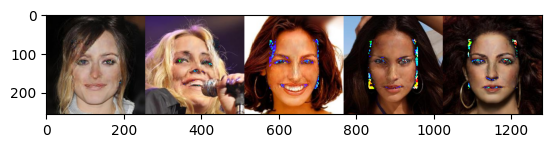

In [17]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

### Test

### **Advanced UNet Model**

In [ ]:
from torchcfm.models.unet import UNetModel

In [ ]:
# sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

# FM = ConditionalFlowMatcher(sigma=sigma)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 10 #1000

for epoch in range(n_epochs):
    losses = []
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(1).to(device)  # Random time step t
        xt = t * x1 + (1 - t) * x0  # Interpolated data point
        ut = x1 - x0  # True difference (velocity)

        # Model prediction
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

In [ ]:
def euler_method(model, x, t_steps, dt, generated_class_list=None):
    y = x
    y_values = [y]  # Store the initial value

    for t in t_steps[1:]:
        dy = model(t, y, generated_class_list)
        y = y + dy * dt  # Euler update step
        y_values.append(y)

    return torch.stack(y_values)

# Initial random image and class (optional)
initial_image = torch.randn(100, 1, 28, 28, device=device)
generated_class_list = torch.randint(0, 10, (100,), device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 2, device=device)
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, initial_image, t_steps, dt, generated_class_list)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()